# Generating captions from images
This notebook builds on the previous caption generation notebook. The key difference however is that the image feature embedding is generated from an image passed through the VGG-16 network, as opposed to just pulling the feature embedding from an already precomputed set of feature embeddings for the Flickr-30K dataset. This allows the user to generate captions for their own images in addition to generating captions for the Flickr-30K images.

*Note:* The `model_path` variable should be the same as the `model_path` variable set in `O'Reilly Training.ipynb`

# Training should be run for at least 1 epoch.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import cv2
import skimage
import datetime
import glob 

import tensorflow.python.platform
from keras.preprocessing import sequence
from collections import Counter


#import matplotlib.image as mpimg

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4860335177509637288, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 12498291983309128223
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:85:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 3929068724431840761
 physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1"]

# Downloading Data
In order to run this notebook you will need to download a pretrained TensorFlow model for [VGG-16](https://drive.google.com/file/d/0B2vTU3h54lTyaDczbFhsZFpsUGs/view?usp=sharing) generated from the original Caffe model from the VGG-16 paper. 

Place this download in the `./data/` folder.

The graph model should now be saved at `./data/vgg16-20160129.tfmodel` .

In [3]:
model_path = './models/tensorflow'
vgg_path = './data/vgg16-20160129.tfmodel'

# Pick your image
Set `image_path` to point to the image you'd like to generate a caption for.

In [4]:
test_images_path = './test_images/'
image_path = './test_images/img1.jpg'

In [5]:
dim_embed = 256
dim_hidden = 256
dim_in = 4096
batch_size = 1
learning_rate = 0.001
momentum = 0.9

In [6]:
class Caption_Generator():
    def __init__(self, dim_in, dim_embed, dim_hidden, batch_size, n_lstm_steps, n_words, init_b=None):

        self.dim_in = dim_in
        self.dim_embed = dim_embed
        self.dim_hidden = dim_hidden
        self.batch_size = batch_size
        self.n_lstm_steps = n_lstm_steps
        self.n_words = n_words
        
        # declare the variables to be used for our word embeddings
        with tf.device("/cpu:0"):
            self.word_embedding = tf.Variable(
                tf.random_uniform([self.n_words, self.dim_embed], -0.1, 0.1), name='word_embedding'
            )

        self.embedding_bias = tf.Variable(tf.zeros([dim_embed]), name='embedding_bias')
        
        # declare the LSTM itself
        self.lstm = tf.contrib.rnn.BasicLSTMCell(dim_hidden)
        
        # declare the variables to be used to embed the image feature embedding to the word embedding space
        self.img_embedding = tf.Variable(tf.random_uniform([dim_in, dim_hidden], -0.1, 0.1), name='img_embedding')
        self.img_embedding_bias = tf.Variable(tf.zeros([dim_hidden]), name='img_embedding_bias')

        # declare the variables to go from an LSTM output to a word encoding output
        self.word_encoding = tf.Variable(tf.random_uniform([dim_hidden, n_words], -0.1, 0.1), name='word_encoding')
        
        # optional initialization setter for encoding bias variable 
        if init_b is not None:
            self.word_encoding_bias = tf.Variable(init_b, name='word_encoding_bias')
        else:
            self.word_encoding_bias = tf.Variable(tf.zeros([n_words]), name='word_encoding_bias')

    def build_model(self):
        # declaring the placeholders for our extracted image feature vectors, our caption, and our mask
        # (describes how long our caption is with an array of 0/1 values of length `maxlen`  
        img = tf.placeholder(tf.float32, [self.batch_size, self.dim_in])
        caption_placeholder = tf.placeholder(tf.int32, [self.batch_size, self.n_lstm_steps])
        mask = tf.placeholder(tf.float32, [self.batch_size, self.n_lstm_steps])
        
        # getting an initial LSTM embedding from our image_imbedding
        image_embedding = tf.matmul(img, self.img_embedding) + self.img_embedding_bias
        
        # setting initial state of our LSTM
        state = self.lstm.zero_state(self.batch_size, dtype=tf.float32)

        total_loss = 0.0
        with tf.variable_scope("RNN"): 
            for i in range(self.n_lstm_steps): 
                if i > 0:
                   #if this isn’t the first iteration of our LSTM we need to get the word_embedding corresponding
                   # to the (i-1)th word in our caption 
                    with tf.device("/cpu:0"):
                        current_embedding = tf.nn.embedding_lookup(self.word_embedding, caption_placeholder[:,i-1]) + self.embedding_bias
                else:
                     #if this is the first iteration of our LSTM we utilize the embedded image as our input 
                    current_embedding = image_embedding
                if i > 0: 
                    # allows us to reuse the LSTM tensor variable on each iteration
                    tf.get_variable_scope().reuse_variables()

                out, state = self.lstm(current_embedding, state)

                
                if i > 0:
                    #get the one-hot representation of the next word in our caption 
                    labels = tf.expand_dims(caption_placeholder[:, i], 1)
                    ix_range=tf.range(0, self.batch_size, 1)
                    ixs = tf.expand_dims(ix_range, 1)
                    concat = tf.concat([ixs, labels],1)
                    onehot = tf.sparse_to_dense(
                            concat, tf.stack([self.batch_size, self.n_words]), 1.0, 0.0)


                    #perform a softmax classification to generate the next word in the caption
                    logit = tf.matmul(out, self.word_encoding) + self.word_encoding_bias
                    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=onehot)
                    xentropy = xentropy * mask[:,i]

                    loss = tf.reduce_sum(xentropy)
                    total_loss += loss

            total_loss = total_loss / tf.reduce_sum(mask[:,1:])
            return total_loss, img,  caption_placeholder, mask


    def build_generator(self, maxlen, batchsize=1):
        #same setup as `build_model` function 
        img = tf.placeholder(tf.float32, [self.batch_size, self.dim_in])
        image_embedding = tf.matmul(img, self.img_embedding) + self.img_embedding_bias
        state = self.lstm.zero_state(batchsize,dtype=tf.float32)

        #declare list to hold the words of our generated captions
        all_words = []
        with tf.variable_scope("RNN"):
            # in the first iteration we have no previous word, so we directly pass in the image embedding
            # and set the `previous_word` to the embedding of the start token ([0]) for the future iterations
            output, state = self.lstm(image_embedding, state)
            previous_word = tf.nn.embedding_lookup(self.word_embedding, [0]) + self.embedding_bias

            for i in range(maxlen):
                tf.get_variable_scope().reuse_variables()

                out, state = self.lstm(previous_word, state)


                # get a one-hot word encoding from the output of the LSTM
                logit = tf.matmul(out, self.word_encoding) + self.word_encoding_bias
                best_word = tf.argmax(logit, 1)

                with tf.device("/cpu:0"):
                    # get the embedding of the best_word to use as input to the next iteration of our LSTM 
                    previous_word = tf.nn.embedding_lookup(self.word_embedding, best_word)

                previous_word += self.embedding_bias

                all_words.append(best_word)

        return img, all_words

In [7]:
 #GET VGG
if not os.path.exists('data/ixtoword.npy'):
    print ('index to word does not exist -> Run training for at least 1 epoch.')
else:
    # generate_VGG()
    tf.reset_default_graph()
    with open(vgg_path,'rb') as f:
        fileContent = f.read()  # open network checkpoint
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(fileContent) 
        
    # generate_ResNETv2()
    
    # 1 or more images 1 -> None
    images = tf.placeholder("float32", [None, 224, 224, 3])
    tf.import_graph_def(graph_def, input_map={ "images":images })
 
    ixtoword = np.load('data/ixtoword.npy').tolist()
    n_words = len(ixtoword)
    maxlen=20
    
    graph = tf.get_default_graph()
    sess = tf.InteractiveSession(graph=graph) # launch interactive session with the loaded graph
    
    # Init the object
    caption_generator = Caption_Generator(dim_in, dim_hidden, dim_embed, batch_size, maxlen+2, n_words)
    print("Creating caption generator object: dim_in={}, dim_hidden={}, dim_embed={}, batch_site={}, max_lenght={}, n_words={}".format( dim_in, dim_hidden, dim_embed, batch_size, maxlen+2, n_words ) )                                                     
    
    graph = tf.get_default_graph()

    # build the generator
    image, generated_words = caption_generator.build_generator(maxlen=maxlen) #build the caption generator model

Creating caption generator object: dim_in=4096, dim_hidden=256, dim_embed=256, batch_site=1, max_lenght=22, n_words=2943


In [8]:
type(image)

tensorflow.python.framework.ops.Tensor

In [8]:
def crop_image(x, target_height=227, target_width=227, as_float=True):
    image = cv2.imread(x)
    if as_float:
        image = image.astype(np.float32)

    if len(image.shape) == 2:
        image = np.tile(image[:,:,None], 3)
    elif len(image.shape) == 4:
        image = image[:,:,:,0]

    height, width, rgb = image.shape
    if width == height:
        resized_image = cv2.resize(image, (target_height,target_width))

    elif height < width:
        resized_image = cv2.resize(image, (int(width * float(target_height)/height), target_width))
        cropping_length = int((resized_image.shape[1] - target_height) / 2)
        resized_image = resized_image[:,cropping_length:resized_image.shape[1] - cropping_length]

    else:
        resized_image = cv2.resize(image, (target_height, int(height * float(target_width) / width)))
        cropping_length = int((resized_image.shape[0] - target_width) / 2)
        resized_image = resized_image[cropping_length:resized_image.shape[0] - cropping_length,:]

    return cv2.resize(resized_image, (target_height, target_width))

In [9]:
def read_image(path):
     img = crop_image(path, target_height=224, target_width=224)
     if img.shape[2] == 4:
         img = img[:,:,:3]

     img = img[None, ...]
     return img

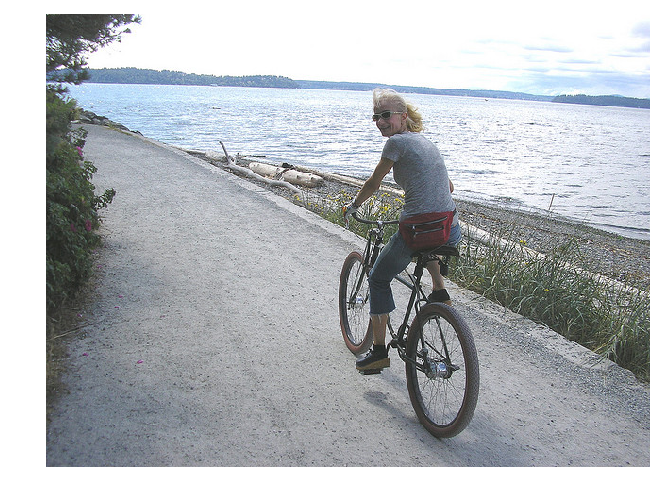

In [10]:
def show_image(image_path):
    %matplotlib inline
    # load the image, convert it to grayscale, and show it
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(8,6), dpi=100)
    plt.axis('off')
    plt.imshow(cv2.cvtColor( np.squeeze(img), cv2.COLOR_BGR2RGB))
    plt.show()
show_image(image_path)

## Note:
In order for the call to `saver.restore(sess, tf.train.latest_checkpoint(model_path))` to work you must have run `O' Reilly Training.ipynb` for 1 full epoch. This is because the call in `O' Reilly Training.ipynb` to save the graph to `model_path` only occurs after successfully completing one full epoch of training. If you would like to run this notebook to sanity check the code, uncomment `sanity_check=True`.

In [11]:
def test(sess, image, generated_words, ixtoword, test_image_path=0): # Naive greedy search
    #if len(test_image_paths) == 0:
    #    print("No image paths specified.")
    #    return
    
    # read the image as tensor
    #images = [read_image(ip) for ip in test_image_paths]
    feat = read_image(test_image_path)
    print(type(feat))
    print feat.shape
    # run pretrained VGG inference to produce image embedding (from ConvNet)
    fc7 = sess.run(graph.get_tensor_by_name("import/Relu_1:0"), feed_dict={images:feat})
    #fc8 = sess.run(graph.get_tensor_by_name("import/Relu_2:0"), feed_dict={images:feat})
    
    saver = tf.train.Saver()
    sanity_check=False
    # sanity_check=True
    
    # restore checkpoint for inference session
    if not sanity_check:
        saved_path=tf.train.latest_checkpoint(model_path)
        saver.restore(sess, saved_path)
    else: # sanity check
        tf.global_variables_initializer().run()
    
    # feed the image embedding from CNN last layer to the LSTM-net
    generated_word_index= sess.run(generated_words, feed_dict={image:fc7})
    
    generated_word_index = np.hstack(generated_word_index) # stack the word embeddings horizontally
    generated_words = [ixtoword[x] for x in generated_word_index] # translate the indices to words
    punctuation = np.argmax( np.array(generated_words) == '.') + 1  # get punctuation index

    generated_words = generated_words[:punctuation] # extract only the words
    generated_sentence = ' '.join(generated_words) # create sentences with white spaaces
    print('[{}]-->[{}]\n'.format(test_image_path, generated_sentence))
    return generated_sentence

In [12]:
# flickr30khttp://ieng6-202.ucsd.edu:9705/tree/oreilly-captions/data/flickr8k/Flicker8k_Dataset
files_flickr8k = glob.glob("./data/flickr8k/Flicker8k_Dataset/*.jpg")
files_flickr30k = glob.glob("./data/flickr30k/flickr30k_images/*.jpg")

In [13]:
rnd8k = np.random.choice(files_flickr8k)
rnd30k = np.random.choice(files_flickr30k)

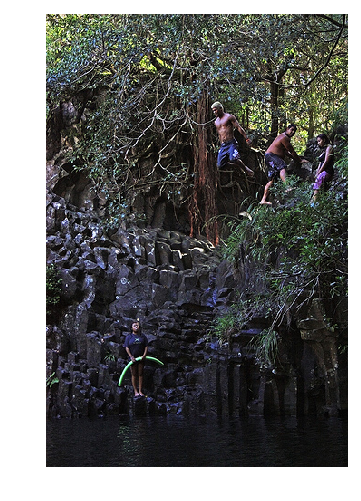

<type 'numpy.ndarray'>
(1, 224, 224, 3)
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1092
[./data/flickr8k/Flicker8k_Dataset/3036971334_78187a9570.jpg]-->[a man is climbing a wall with a large rock wall in the background .]



In [14]:
show_image(rnd8k)
sentence = test(sess, image, generated_words, ixtoword, rnd8k)

with open('test_{}'.format(datetime.datetime.now().strftime('%m_%d_%Y')),'a') as f:
    f.write('{} --> {}\n'.format(rnd8k, sentence))

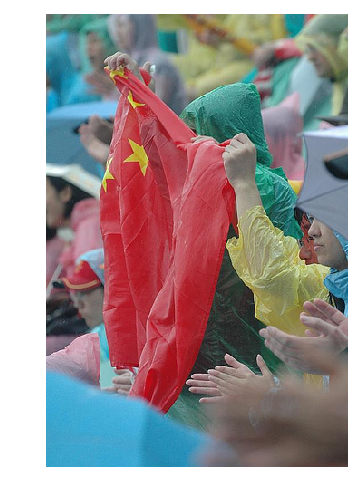

<type 'numpy.ndarray'>
(1, 224, 224, 3)
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-244
[./data/flickr30k/flickr30k_images/2845080955.jpg]-->[a man is holding a large bowl of fruit .]



In [21]:
show_image(rnd30k)
sentence = test(sess, image, generated_words, ixtoword, rnd30k)

with open('test_{}'.format(datetime.datetime.now().strftime('%m_%d_%Y')),'a') as f:
    f.write('{} --> {}\n'.format(rnd30k, sentence))

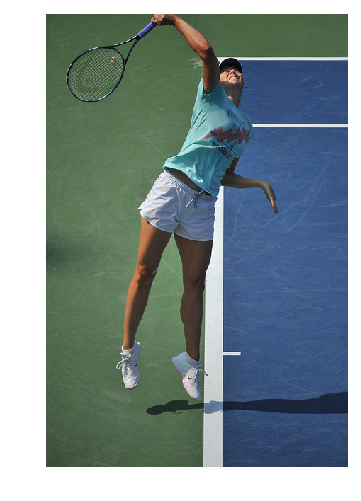

<type 'numpy.ndarray'>
(1, 224, 224, 3)
INFO:tensorflow:Restoring parameters from ./models/tensorflow/model-1092
[./test_images/img21.jpg]-->[a man in a black shirt and jeans is flipping a basketball in a fencing competition .]



In [21]:
image_path = './test_images/img21.jpg'
show_image(image_path)
sentence = test(sess, image, generated_words, ixtoword, image_path)

with open('test_{}'.format(datetime.datetime.now().strftime('%m_%d_%Y')),'a') as f:
    f.write('{} --> {}\n'.format(image_path, sentence))

Previous checkpoint from ./models/tensorflow, Epochs 1009, iterations: 129152


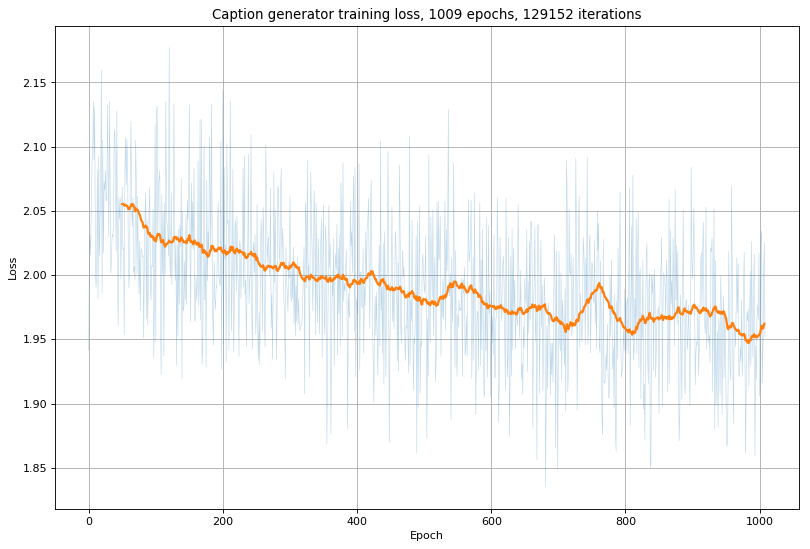

In [33]:
training_batch_size = 128

%matplotlib inline
fig = plt.figure(figsize=(12,8), dpi=80)
losses = np.load('losses.npy')[0::training_batch_size]
filter_size = math.floor(losses.shape[0]/( 20.) )
losses_c = np.convolve(losses, [1/filter_size]*int(filter_size) )
losses_c2 = np.convolve(losses, [1/filter_size]*int(filter_size) )

last_epoch = len(losses)
itr = last_epoch*training_batch_size
# not test batch_size (=1)

print('Previous checkpoint from {}, Epochs {}, iterations: {}'.format( model_path, last_epoch , itr))

plt.plot(range( len(losses)) ,
         losses, 
         '-', markersize=1, linewidth=0.5, alpha=0.3)
plt.plot(range(int(filter_size),len(losses_c)-int(filter_size)),  
         losses_c[int(filter_size):-int(filter_size)],
         '-', linewidth=2)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Caption generator training loss, {} epochs, {} iterations'.format(last_epoch,itr))
plt.show()
fig.savefig("Training_loss_epoch_{}.png".format(last_epoch))